In [405]:
#loading required libraries
import pandas as pd
import numpy as np

# Visualisations
import matplotlib.pyplot as plt

# Correlation test
from scipy import stats
from scipy.stats import pearsonr

# RMSE
from sklearn.metrics import mean_squared_error,r2_score

# Splitting the data
from sklearn.model_selection import train_test_split

# Linear Regression library
from sklearn.linear_model import LinearRegression

# Statitistical Tests - Z-Test
from statsmodels.stats.weightstats import ztest as ztest

# OLS Regression
import statsmodels.api as sm

#Suppressing warnings
import warnings
warnings.filterwarnings("ignore")


In [406]:
# loading required dataset

# MODIS Dataset
bauchi_modis=pd.read_csv('Bauchi-MODIS.csv')
plateau_modis= pd.read_csv('Plateau-MODIS.csv')

# VIIRS Dataset
bauchi_viirs = pd.read_csv('Bauchi-VIIRS.csv')
plateau_viirs = pd.read_csv('Plateau-VIIRS.csv')

## Understanding the data

### Region: Bauchi

In [407]:
bauchi_modis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   system:time_start  549 non-null    object 
 1   NDVI               549 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.7+ KB


In [408]:
bauchi_viirs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   system:time_start  550 non-null    object 
 1   NDVI               550 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.7+ KB


- Both datasets do not contain missing values.
- The date is an object datatype

### Region: Plateau

In [409]:
plateau_modis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   system:time_start  549 non-null    object 
 1   NDVI               549 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.7+ KB


In [410]:
plateau_viirs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   system:time_start  550 non-null    object 
 1   NDVI               550 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.7+ KB


- Both datasets do not contain missing values.
- The date is an object datatype

## Function To be applied

In [411]:
# Function that performs resampling and merging 

def resampling(data1, data2):

    # For Modis data
    data1['date'] = pd.to_datetime(data1['system:time_start']) #Converting the date to a datetime object
    data1.set_index('date', inplace=True)                      # Setting the datetime as index
    data1.drop(['system:time_start'], axis=1, inplace=True)    # Dropping unnnecessary columns
    resampled_data1 = data1.resample('M').mean()               # Performing resampling by the mean

        # For Viirs data 
    data2['date'] = pd.to_datetime(data2['system:time_start'])  # Converting the date to a datetime object
    data2.set_index('date', inplace=True)                      # Setting the datetime as index
    data2.drop(['system:time_start'], axis=1, inplace=True)    # Dropping unnecessary columns 
    resampled_data2 = data2.resample('M').mean()               # Performing resampling by the mean    
    merged_df = pd.merge(resampled_data1, resampled_data2, left_index=True, right_index=True)  # Merging the two dataframes
    
    return [merged_df,resampled_data1, resampled_data2]    

# More Analysis

## Region: Bauchi

### Correlation Test without Resampling

In [412]:
# Converting the date to a datetime object
bauchi_modis_unsampled = bauchi_modis
bauchi_viirs_unsampled =  bauchi_viirs
bauchi_modis_unsampled['date'] = pd.to_datetime(bauchi_modis_unsampled['system:time_start']) #Converting the date to a datetime object
bauchi_viirs_unsampled['date'] = pd.to_datetime(bauchi_viirs_unsampled['system:time_start']) #Converting the date to a datetime object

# Merging the two Datasets
merged_df_unsampled_bauchi = pd.merge(bauchi_modis_unsampled, bauchi_viirs_unsampled, on=['date'], how='inner',)

# Dropping unnecessary columns
merged_df_unsampled_bauchi.drop(['system:time_start_x','system:time_start_y'],axis=1,inplace=True)

## Calculate Pearson correlation coefficient 
correlation_coefficient, p_value = pearsonr(merged_df_unsampled_bauchi['NDVI_x'], merged_df_unsampled_bauchi['NDVI_y'])

# Display the results
print(f"Pearson Correlation Coefficient(without_Resampling): {correlation_coefficient}")

Pearson Correlation Coefficient(without_Resampling): 0.9842276711662477


### Correlation Test with Resampling

In [413]:
## Applying the function
resample_bauchi_merged_df = resampling(bauchi_modis, bauchi_viirs)[0]

## Calculate Pearson correlation coefficient 
correlation_coefficient, p_value = pearsonr(resample_bauchi_merged_df['NDVI_x'], resample_bauchi_merged_df['NDVI_y'])

# Display the results
print(f"Pearson Correlation Coefficient(With Resampling): {correlation_coefficient}")


Pearson Correlation Coefficient(With Resampling): 0.9919022766579455


### Checking the RMSE

In [414]:
# Definining the actual and predicted
y_actual=resample_bauchi_merged_df['NDVI_y']  # VIIRS NDVI
y_predicted=resample_bauchi_merged_df['NDVI_x'] #MODIS NDVI

# Performing the RMSE
bauchi_rmse = mean_squared_error(y_actual, y_predicted, squared=False)
bauchi_rmse

0.025003886657754375

### Hypothesis Testing

1.Hypothesis
- Null hypothesis: VIIRS NDVI is not equal to MODIS NDVI
- Alternative hypothesis : VIIRS NDVI is equal to MODIS NDVI

2.Significance level(alpha=0.05)

3.Test Statistic - Z test (large sample size and known standard deviation)

3.Critical Value / P-value

4.Decision

In [415]:
#Significance Level
alpha = 0.05

# Performing Z-Test
results = ztest(resample_bauchi_merged_df['NDVI_x'],resample_bauchi_merged_df['NDVI_y'],value=0)
# Calculating Z-tabulated (critical value)
z_critical_bauchi = stats.norm.ppf(1 - alpha/2)
# Decision - Z-Test
if np.abs(results[0]) > z_critical_bauchi:
    print("""Reject the null hypothesis.There is no significant difference between VIIRS and MODIS. Hence VIIRS and MODIS are equal""")
else:
    print("""Fail to reject the null hypothesis.There is a significant difference between VIIRS and MODIS. Hence VIIRS and MODIS are not equal""")


## Using P-VALUE
# Calculate p-value
p_value_bauchi = 2 * (1 - stats.norm.cdf(np.abs(results[0])))  # Two-tailed test
# Decision - P-Value
if p_value_bauchi < alpha:
    print("Reject the null hypothesis. There is no significant difference. Hence VIIRS and MODIS are equal")
else:
    print("Fail to reject the null hypothesis. There is a significant difference. Hence VIIRS and MODIS are not equal")


Fail to reject the null hypothesis.There is a significant difference between VIIRS and MODIS. Hence VIIRS and MODIS are not equal
Fail to reject the null hypothesis. There is a significant difference. Hence VIIRS and MODIS are not equal


## Region: Plateau

### Correlation Test without Resampling

In [416]:
# Converting the date to a datetime object
plateau_modis_unsampled = plateau_modis
plateau_viirs_unsampled =  plateau_viirs
plateau_modis_unsampled['date'] = pd.to_datetime(plateau_modis_unsampled['system:time_start']) #Converting the date to a datetime object
plateau_viirs_unsampled['date'] = pd.to_datetime(plateau_viirs_unsampled['system:time_start']) #Converting the date to a datetime object

# Merging the two Datasets
merged_df_unsampled_plateau = pd.merge(plateau_modis_unsampled, plateau_viirs_unsampled, on=['date'], how='inner',)

# Dropping unnecessary columns
merged_df_unsampled_plateau.drop(['system:time_start_x','system:time_start_y'],axis=1,inplace=True)

## Calculate Pearson correlation coefficient 
correlation_coefficient, p_value = pearsonr(merged_df_unsampled_plateau['NDVI_x'], merged_df_unsampled_plateau['NDVI_y'])

# Display the results
print(f"Pearson Correlation Coefficient(without_Resampling): {correlation_coefficient}")


Pearson Correlation Coefficient(without_Resampling): 0.933863054851532


### Correlation Test with Resampling

In [417]:
## Applying the function
resample_plateau_merged_df = resampling(plateau_modis, plateau_viirs)

# Extracting Modis resampled data
resample_plateau_modis_df = resample_plateau_merged_df[1]

## Calculate Pearson correlation coefficient 
correlation_coefficient, p_value = pearsonr(resample_plateau_merged_df[0]['NDVI_x'], resample_plateau_merged_df[0]['NDVI_y'])

# Display the results
print(f"Pearson Correlation Coefficient(With Resampling): {correlation_coefficient}")



Pearson Correlation Coefficient(With Resampling): 0.9603648984788874


- High correlation results in multicollinearity,which won’t render our model unusable if violated, but it will cause issues with the interpretability of the model.

### Checking the RMSE

In [418]:
# Definining the actual and predicted
y_actual=resample_plateau_merged_df[0]['NDVI_y']  # VIIRS NDVI
y_predicted=resample_plateau_merged_df[0]['NDVI_x'] #MODIS NDVI

# Performing the RMSE
plateau_rmse = mean_squared_error(y_actual, y_predicted, squared=False)
plateau_rmse

0.05859859537578893

### Hypothesis Testing

1.Hypothesis
- Null hypothesis: VIIRS NDVI is not equal to MODIS NDVI
- Alternative hypothesis : VIIRS NDVI is equal to MODIS NDVI

2.Significance level(alpha=0.05)

3.Test Statistic - Z test (large sample size and known standard deviation)

3.Critical Value / P-value

4.Decision

In [419]:
#Significance Level
alpha = 0.05

# Performing Z-Test
results_plateau = ztest(resample_plateau_merged_df[0]['NDVI_x'],resample_plateau_merged_df[0]['NDVI_y'],value=0)
# Calculating Z-tabulated (critical value)
z_critical_plateau = stats.norm.ppf(1 - alpha/2)
# Decision - Z-Test
if np.abs(results_plateau[0]) > z_critical_plateau:
    print("""Reject the null hypothesis.There is no significant difference between VIIRS and MODIS. Hence VIIRS and MODIS are equal""")
else:
    print("""Fail to reject the null hypothesis.There is a significant difference between VIIRS and MODIS. Hence VIIRS and MODIS are not equal""")


## Using P-VALUE
# Calculate p-value
p_value_plateau = 2 * (1 - stats.norm.cdf(np.abs(results_plateau[0])))  # Two-tailed test
# Decision - P-Value
if p_value_plateau < alpha:
    print("Reject the null hypothesis. There is no significant difference. Hence VIIRS and MODIS are equal")
else:
    print("Fail to reject the null hypothesis. There is a significant difference. Hence VIIRS and MODIS are not equal")


Reject the null hypothesis.There is no significant difference between VIIRS and MODIS. Hence VIIRS and MODIS are equal
Reject the null hypothesis. There is no significant difference. Hence VIIRS and MODIS are equal


### Fitting a Regression Model

In [420]:
# Defining the dependent and independent variable
X = resample_plateau_merged_df[0].iloc[:, :-1].values  #MODIS NDVI
y = resample_plateau_merged_df[0].iloc[:,1].values  # VIIRS NDVI

# Adding a constant term to the independent variable (for the intercept)
X = sm.add_constant(X)

# Splitting the dataset into training set and testing set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Fitting the OLS regression model
model = sm.OLS(y_train, X_train).fit()

# Displaying the regression summary
print(model.summary())




                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1438.
Date:                Thu, 25 Jan 2024   Prob (F-statistic):           4.16e-66
Time:                        16:26:51   Log-Likelihood:                 212.21
No. Observations:                 115   AIC:                            -420.4
Df Residuals:                     113   BIC:                            -414.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.013     -0.224      0.8

In [421]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred

array([0.50282241, 0.57829413, 0.29679011, 0.31552032, 0.27750901,
       0.68957361, 0.36399851, 0.53532483, 0.61520366, 0.47197265,
       0.49290642, 0.31496943, 0.3645494 , 0.6758014 , 0.54028283,
       0.70114227, 0.33149608, 0.67194518, 0.56727636, 0.36510028,
       0.29789189, 0.67194518, 0.29458656, 0.32488542, 0.56892903,
       0.50888218, 0.31882565, 0.66258008, 0.54744438])

In [422]:
# Evaluating the model- RMSE
mean_squared_error(y_test, y_pred)


0.0020835942550963145

In [423]:
# Using R-squared
r2_score(y_test,y_pred)

0.9035448851317363

<Axes: >

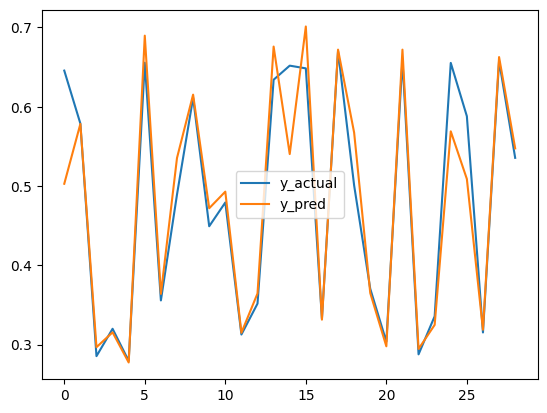

In [424]:
pd.DataFrame({'y_actual':y_test, 'y_pred':y_pred}).plot()

In [425]:
# Filter the DataFrame for the date range 2000-01-01 to 2011-12-31
resample_plateau_modis_filtered = resample_plateau_modis_df.loc['2000-01-01':'2011-12-31']

# Creating an array of the filtered dataframe
resample_plateau_modis_array = resample_plateau_modis_filtered['NDVI'].to_numpy()
resample_plateau_modis_array = np.column_stack((np.ones_like(resample_plateau_modis_array), resample_plateau_modis_array))

#Using the trained model to predict VIIRS values
viirs_predictions = model.predict(resample_plateau_modis_array)
viirs_predictions
# Adding the VIIRS predictions as a new column to the dataframe
resample_plateau_modis_filtered['VIIRS_Predictions']=viirs_predictions


# Retrieving Modis Values
modis_values = resample_plateau_modis_filtered['NDVI']

# Calculating the difference between MODIS values and VIIRS predictions
difference=modis_values-viirs_predictions

# Add the difference as a new column to the DataFrame
resample_plateau_modis_filtered['Difference'] = difference
resample_plateau_modis_filtered

,NDVI,VIIRS_Predictions,Difference
date,,,
2000-02-29,0.2390,0.260431,-0.021431
2000-03-31,0.2570,0.280263,-0.023263
2000-04-30,0.2975,0.324885,-0.027385
2000-05-31,0.4570,0.500619,-0.043619
2000-06-30,0.5735,0.628976,-0.055476
...,...,...,...
2011-08-31,0.4960,0.543588,-0.047588
2011-09-30,0.6085,0.667538,-0.059038
2011-10-31,0.5920,0.649359,-0.057359


In [426]:
(sum(resample_plateau_modis_filtered['Difference']**2)/resample_plateau_modis_filtered['Difference'].shape[0])**0.5

0.04361038280324743

In [427]:
mean_squared_error(resample_plateau_modis_filtered['NDVI'], resample_plateau_modis_filtered['VIIRS_Predictions'], squared=False)


0.04361038280324743